In [1]:
import utils.dataset_utils as dataset
import utils.train_utils as train

from os import path
import numpy as np
import copy
import pickle

from sklearn.base import BaseEstimator, ClassifierMixin
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from scipy.fft import fft, ifft, fftfreq

from datetime import datetime
from dateutil.relativedelta import relativedelta
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (20.0, 10.0)
plt.rcParams['figure.dpi'] = 100
from IPython.display import display, HTML
display(HTML("<style>.container { width:98% !important; }</style>"))

In [2]:
def unit_vector_norm(X):
    return (X.T / np.sqrt((X**2).sum(axis=1))).T

In [3]:
NORMALIZE = False
file_location = "../data/Raman_Mouse/approximated_curve_fit/"
file_location_org = "../data/Raman_Mouse/corrected_4_wavenumbers/"
filenames = np.load(f"{file_location}FileNames.npy")
with open(f'../data/Raman_Mouse/Sample_labels.pickle', 'rb') as f:
    labels = pickle.load(f)

vector_norm = unit_vector_norm if NORMALIZE else lambda x: x
    
data = []
for f in filenames:
    raw = np.load(f"{file_location_org}{f.split('.')[0]}.npy")
    raman = np.load(f"{file_location}{f.split('.')[0]}_raman.npy")
    photo = np.load(f"{file_location}{f.split('.')[0]}_photoluminescence.npy")
    data.append((vector_norm(raw.reshape(-1,raw.shape[-1])).reshape(raw.shape),
#                  vector_norm(raw.reshape(-1,raw.shape[-1])).reshape(raw.shape),
#                  vector_norm(raw.reshape(-1,raw.shape[-1])).reshape(raw.shape),
#                  vector_norm((raman+photo).reshape(-1,raman.shape[-1])).reshape(raman.shape),
                 vector_norm(raman.reshape(-1,photo.shape[-1])).reshape(photo.shape), 
#                  vector_norm(photo.reshape(-1,photo.shape[-1])).reshape(photo.shape), 
                 vector_norm(raw.reshape(-1,raw.shape[-1])).reshape(raw.shape),
                 labels[f]))
#     data.append((raw,
#                  raman,
#                  vector_norm(photo.reshape(-1,photo.shape[-1])).reshape(photo.shape), 
#                  labels[f]))

In [4]:
nn.ReLU
nn.GELU
nn.LeakyReLU
nn.Tanh

"""
Keep sum of weights positive
"""

class Conv_FFT(nn.Module):
    def __init__(self, num_input_channels : int = 2, base_channel_size: int = 16, act_fn : object = nn.LeakyReLU, groups : int = 2, **kwargs):
        super().__init__()
        c_hid = base_channel_size
        self.net = nn.Sequential(
            nn.Conv1d(num_input_channels, c_hid, kernel_size=11, padding=5, groups=groups), 
            act_fn(),
            nn.Conv1d(c_hid, c_hid, kernel_size=7, padding=3, groups=groups),
            act_fn(),
            nn.Conv1d(c_hid, c_hid, kernel_size=5, padding=2, groups=groups),
            act_fn(),
            nn.Conv1d(c_hid, num_input_channels, kernel_size=3, padding=1, groups=groups)
        )
        
    def forward(self, x):
        d = 1
        x = torch.fft.fft(x, dim=d, norm='backward')
        x = torch.stack((x.real, x.imag), 1)
        x = self.net(x)
        x = torch.transpose(x, -2, -1).contiguous()
        x = torch.view_as_complex(x)
        return torch.fft.ifft(x, dim=d, norm='backward').real
    
#     def forward(self, x):
#         x = x.reshape(-1, 1, x.shape[-1])
#         x = self.net(x).reshape(x.shape[0],-1)
#         return x

In [5]:
class SupervisedClassifier(BaseEstimator):
    def __init__(self, **kwargs):
        self.kwargs = kwargs

        _use_cuda = torch.cuda.is_available() and kwargs['cuda']
        if _use_cuda:
            torch.backends.cudnn.enabled = True
            torch.backends.cudnn.benchmark = True
        self.device = torch.device('cuda' if _use_cuda else 'cpu')        
        print(f"device: {self.device}")
        
    def fit(self, data):
        self.model = Conv_FFT().to(self.device)

        parameters = filter(lambda x: x.requires_grad, self.model.parameters())
        self.optimizer = optim.Adam(parameters, lr=self.kwargs['lr'])                
        train_loader, test_loader = dataset.load_splitdata(data, self.kwargs['batch_size'])
        
        for epoch in range(self.kwargs['epochs']):
#             if path.exists(f"Conv_FFT_model_epoch{epoch}.pt"):
#                 print(f"epoch {epoch} is already trained")
#                 if not path.exists(f"Conv_FFT_model_epoch{epoch+1}.pt"):
#                     self.model = torch.load(f"Conv_FFT_model_epoch{epoch}.pt")
#                 continue 
#             if epoch == 1:
#                 for param_group in self.optimizer.param_groups:
#                     param_group['lr'] = 0.0005  
#             elif epoch == 5:
#                 for param_group in self.optimizer.param_groups:
#                     param_group['lr'] = 0.0001
#             elif epoch == 10:
#                 for param_group in self.optimizer.param_groups:
#                     param_group['lr'] = 0.00005
            print('-'*50)
            print('Epoch {:3d}/{:3d}'.format(epoch+1, self.kwargs['epochs']))
            start_time = datetime.now()
            train.train(self.model, self.optimizer, train_loader, self.kwargs['loss_func'], self.kwargs['acc_func'], self.kwargs['log_step'], self.device)
            end_time = datetime.now()
            time_diff = relativedelta(end_time, start_time)
            print('Elapsed time: {}h {}m {}s'.format(time_diff.hours, time_diff.minutes, time_diff.seconds))
            train.test(self.model, test_loader, self.kwargs['loss_func'], self.kwargs['loss_func'], self.device)
            torch.save(self.model, f"Conv_FFT_model_epoch{epoch}.pt")
        return self
    
    def predict(self, X):
        """
        predict transforms the data into the reference space. Min weight should be 0 or higher then 'min_weight'
        The error is the NMSE, where the MSE is normalised by the signal strength. 
        error.shape = X.shape[0], so for each data point the error is calculated.
        """
        # Check is fit had been called
        check_is_fitted(self)

        # Input validation
        X = check_array(X)
#         self.model(X)
        
#         return RCA_vector

In [6]:
loss1 = nn.MSELoss(size_average=None, reduce=None, reduction='mean')
# loss2 = nn.L1Loss(size_average=None, reduce=None, reduction='mean')
# loss3 = nn.KLDivLoss(size_average=None, reduce=None, reduction='batchmean', log_target=False)
# both closely related
# loss4 = nn.HuberLoss(reduction='mean', delta=100.0)
# loss5 = nn.SmoothL1Loss(size_average=None, reduce=None, reduction='mean', beta=1.0)

def loss_func(y, y_):
    raman, photo, _ = y
    raman = raman.to(y_.device)
    photo = photo.to(y_.device)
    return loss1(y_, raman)

def acc_func(y, y_):
    y_clone = torch.clone(y_)
    y_clone = y_clone.cpu().detach().numpy()
    plt.plot(y[0][0], label='smooth')
    plt.plot(y[1][0], label='raw')
    plt.plot(y_clone[0], label='Conv')
    plt.legend()
    plt.show()
    return loss_func(y, y_)

In [7]:
BATCH_SIZE = 64
EPOCHS = 10

kwargs = {'batch_size': BATCH_SIZE,
          'cuda': True,
          'log_step': 100,
          'epochs': EPOCHS,
          'loss_func': loss_func,
          'acc_func' : acc_func,
          'bias': True,
          'lr': 0.001
         }

device: cpu
--------------------------------------------------
Epoch   1/ 10


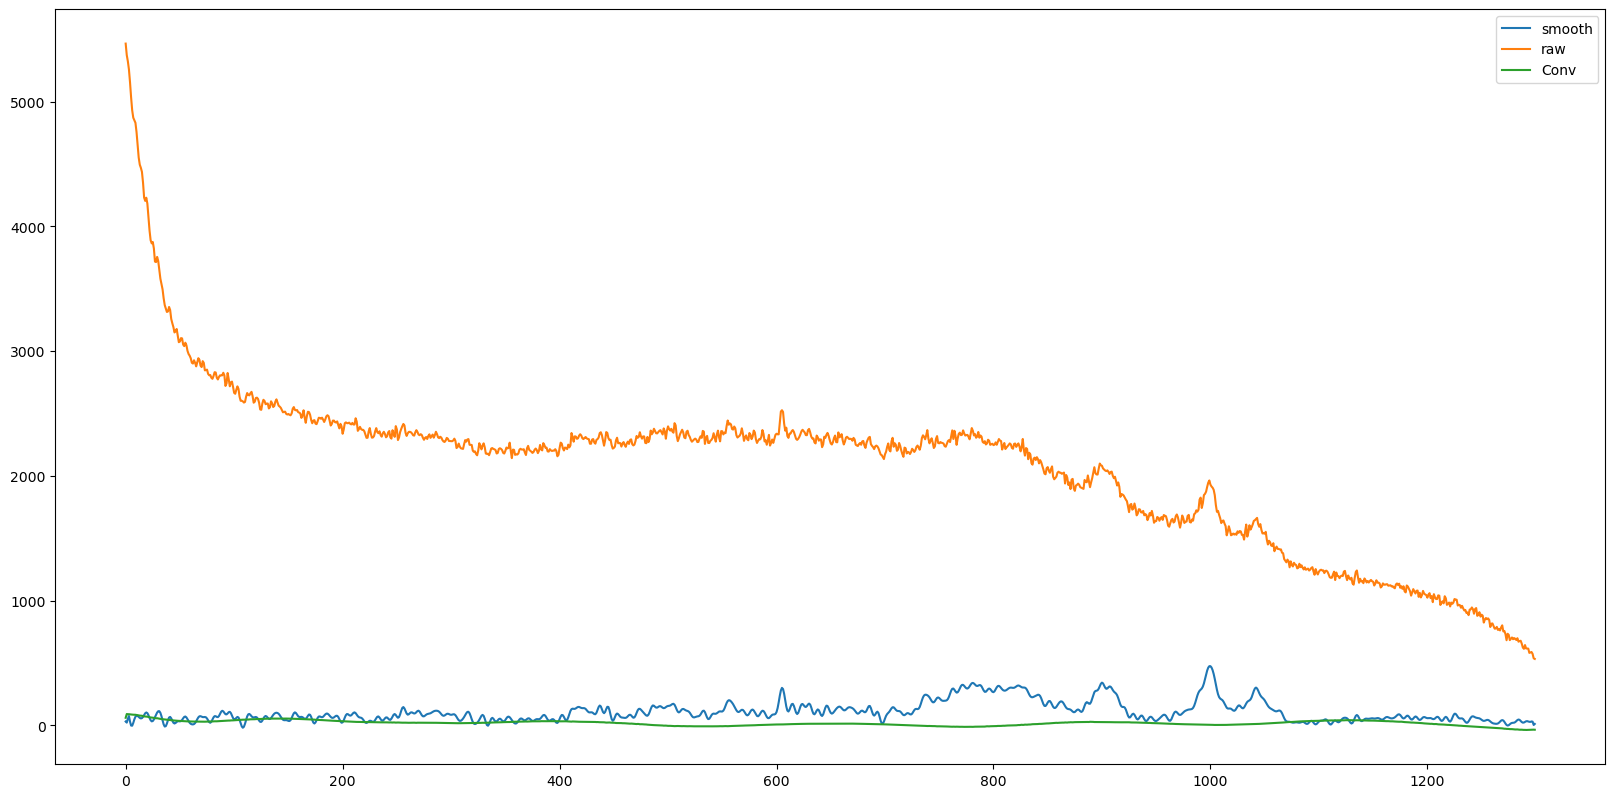

  2022-09-28 18:09:14|     0/ 2695| bits: 18698.111328


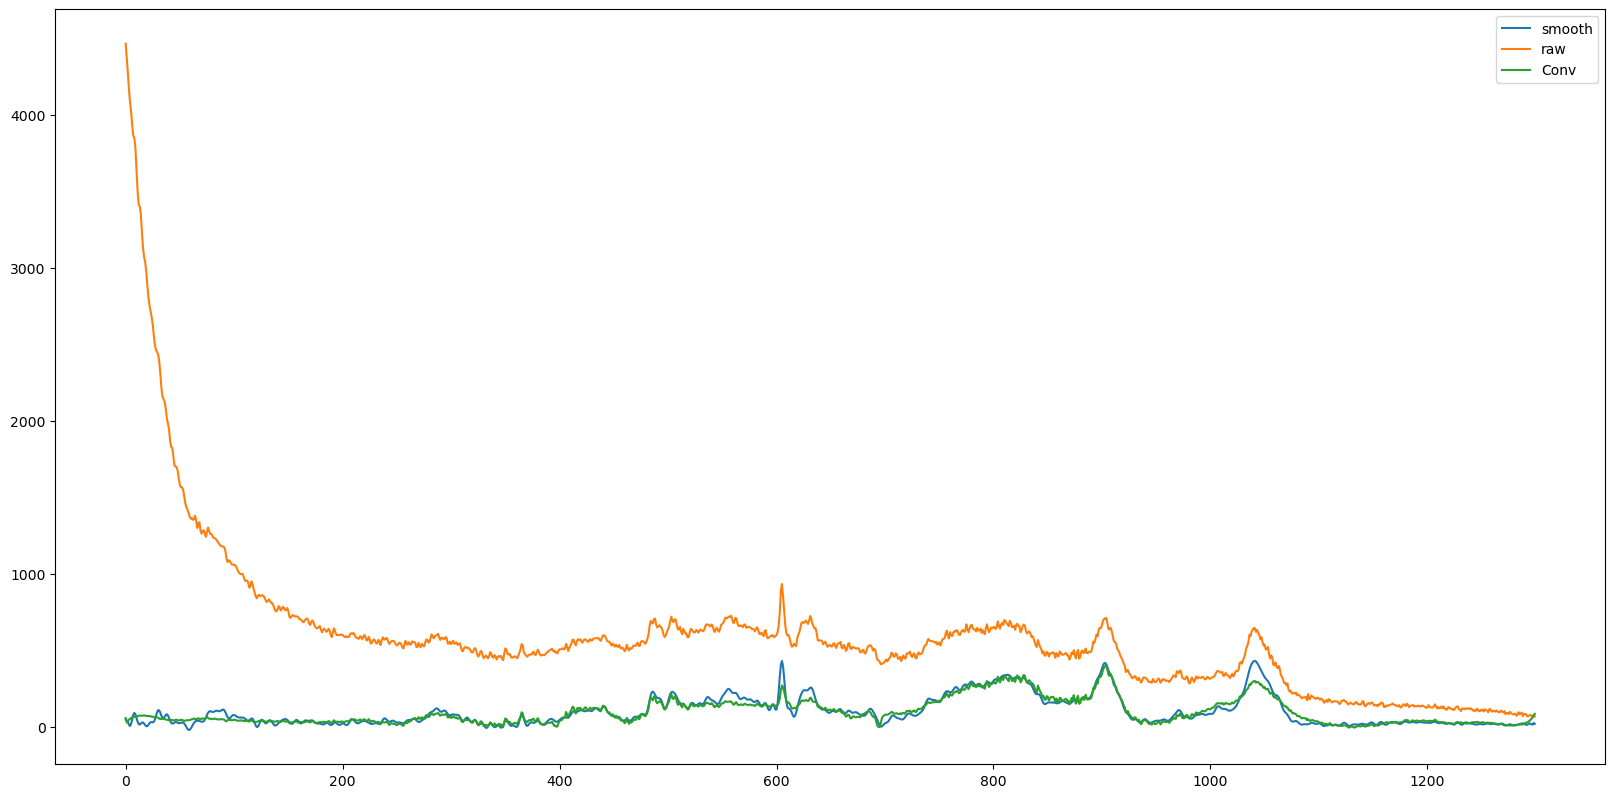

  2022-09-28 18:09:18|   100/ 2695| bits: 527.647766


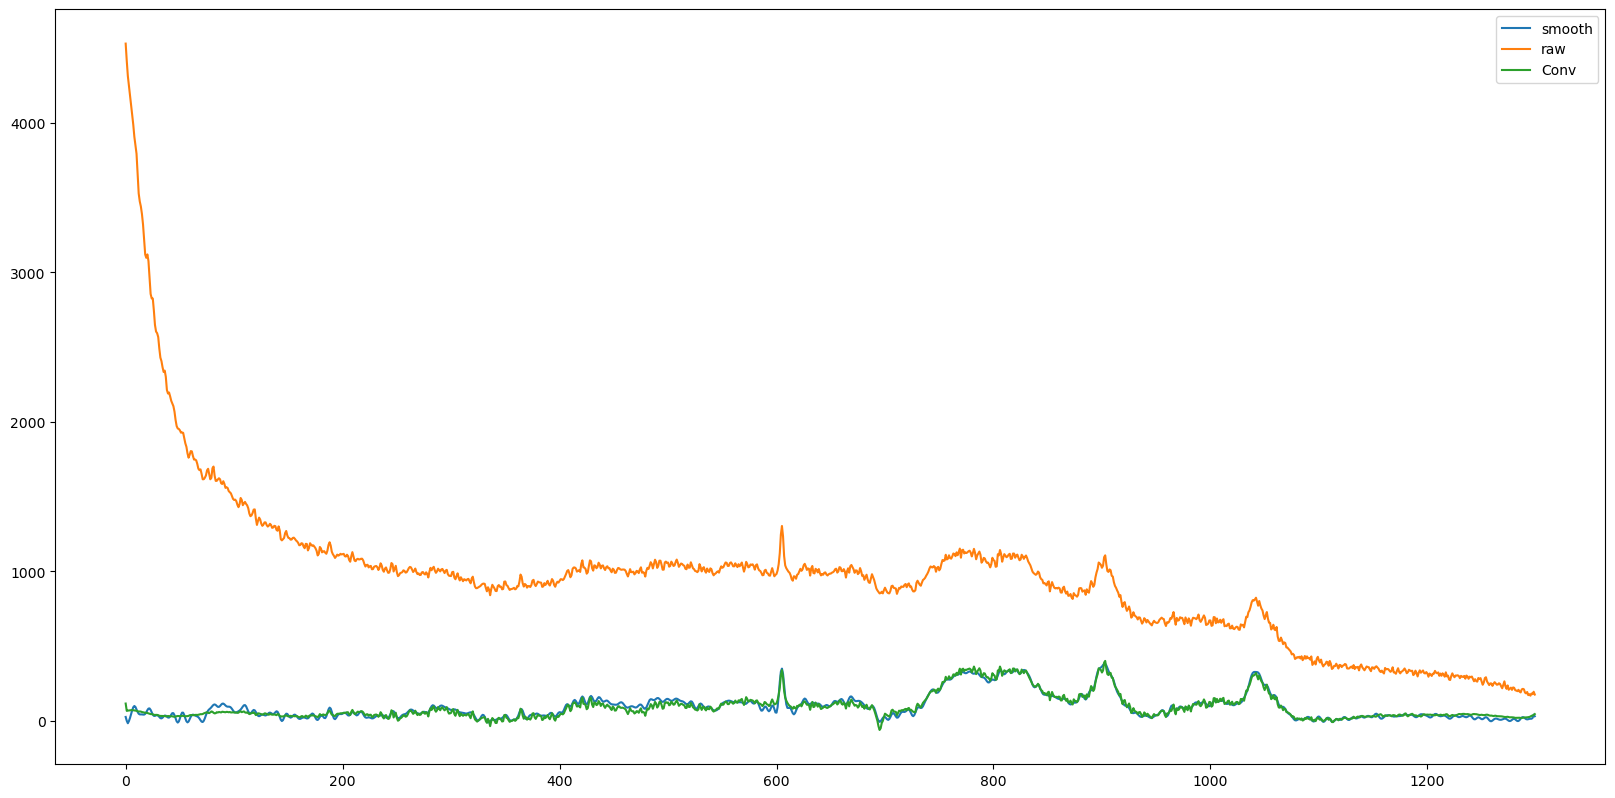

  2022-09-28 18:09:21|   200/ 2695| bits: 1097.386353


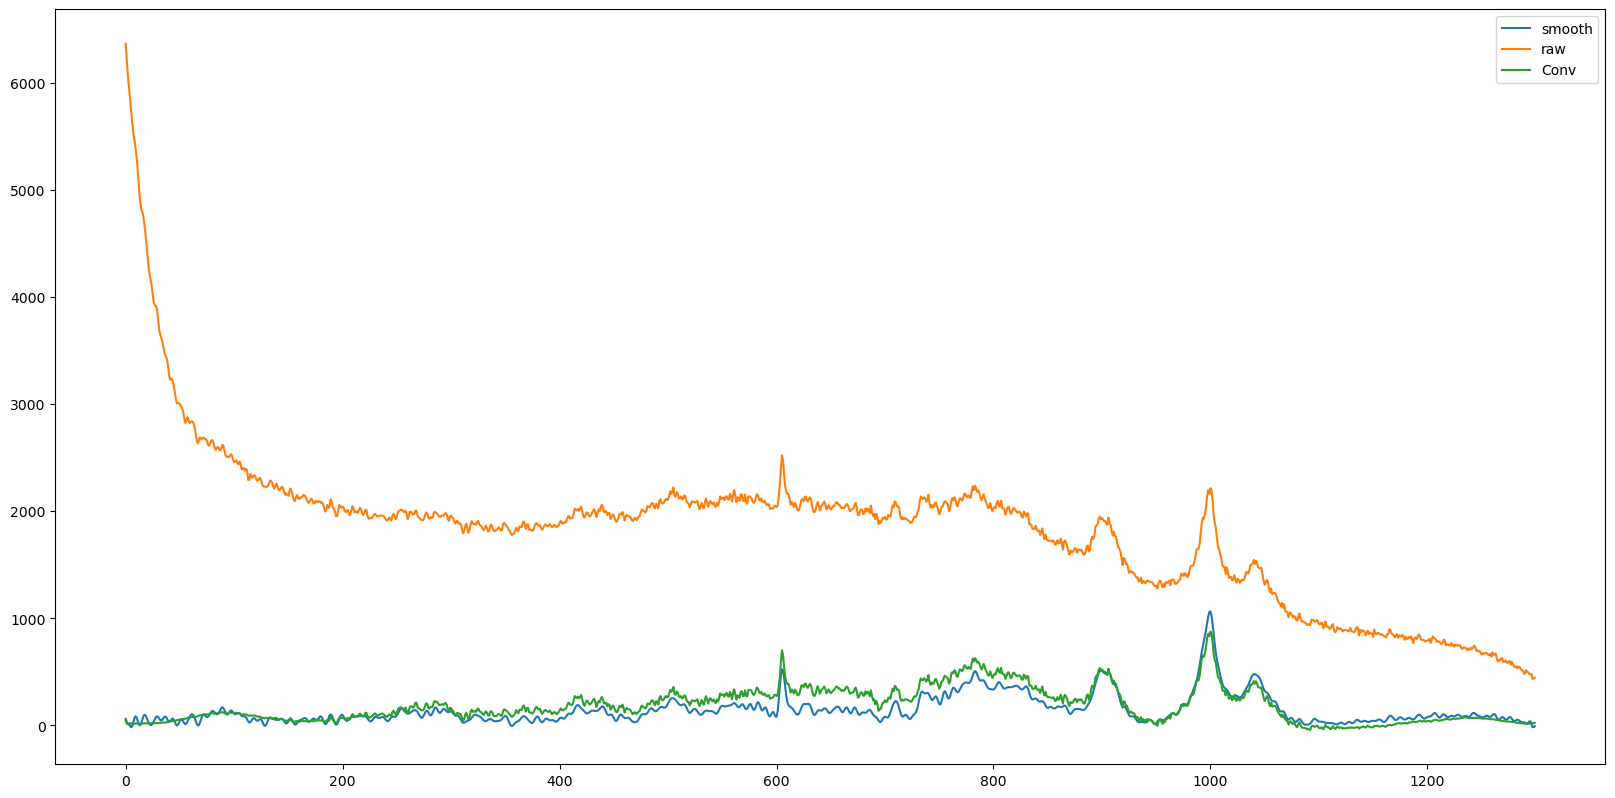

  2022-09-28 18:09:24|   300/ 2695| bits: 3478.975342


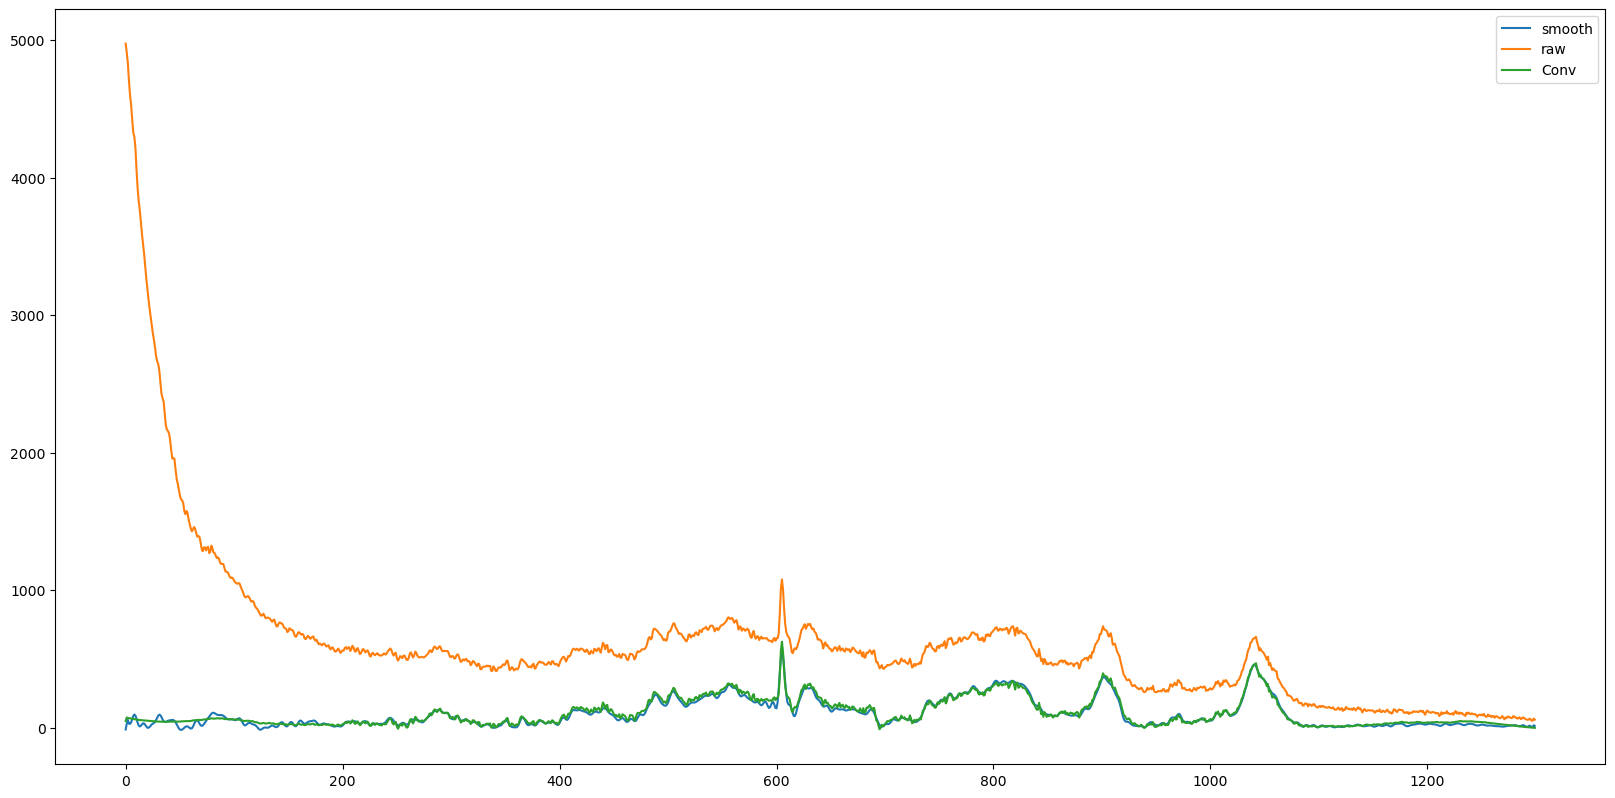

  2022-09-28 18:09:28|   400/ 2695| bits: 795.764648


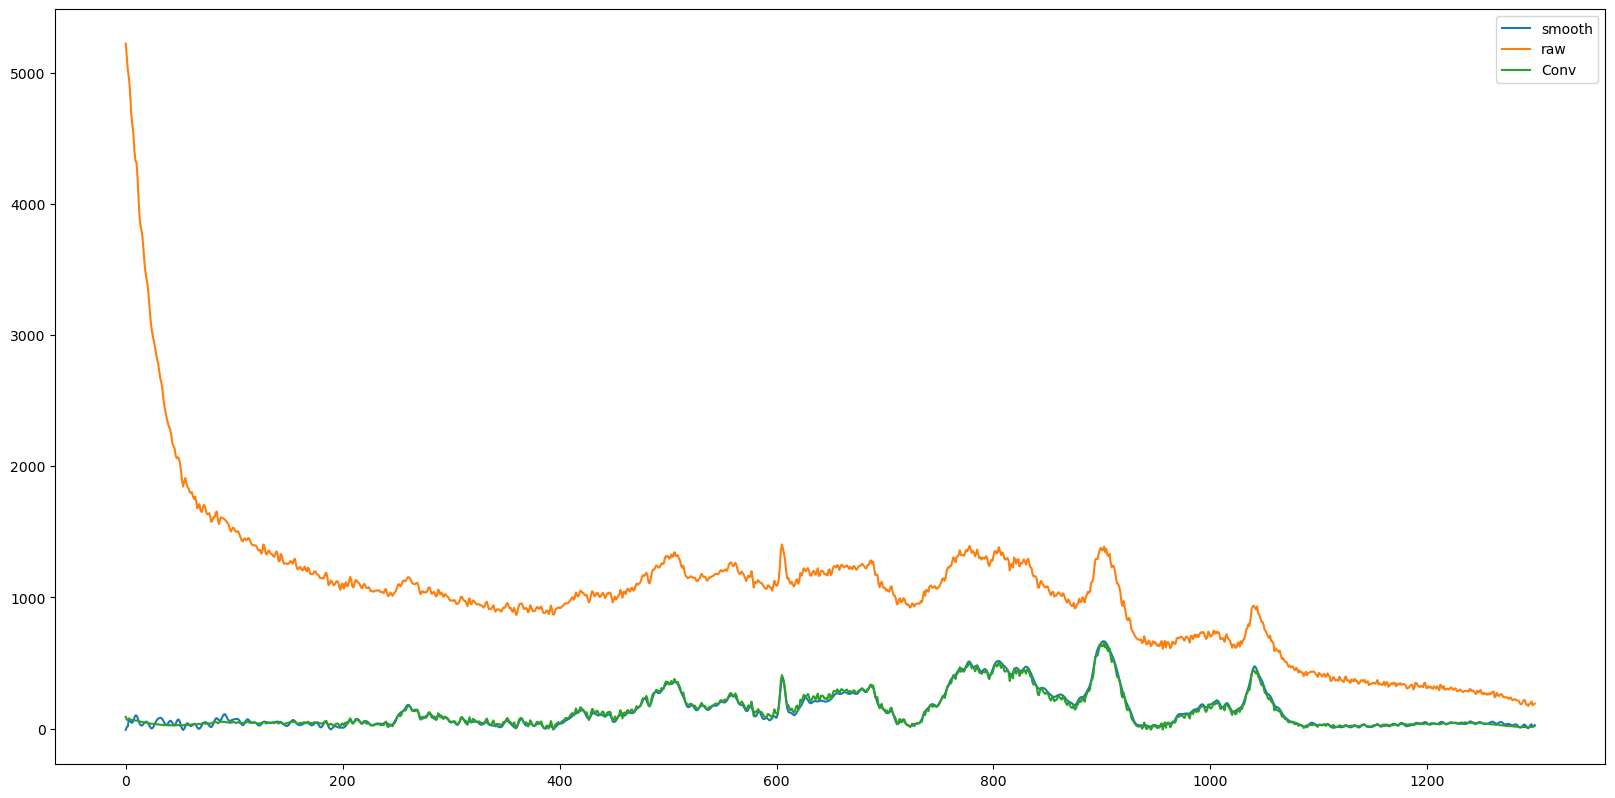

  2022-09-28 18:09:32|   500/ 2695| bits: 469.516052


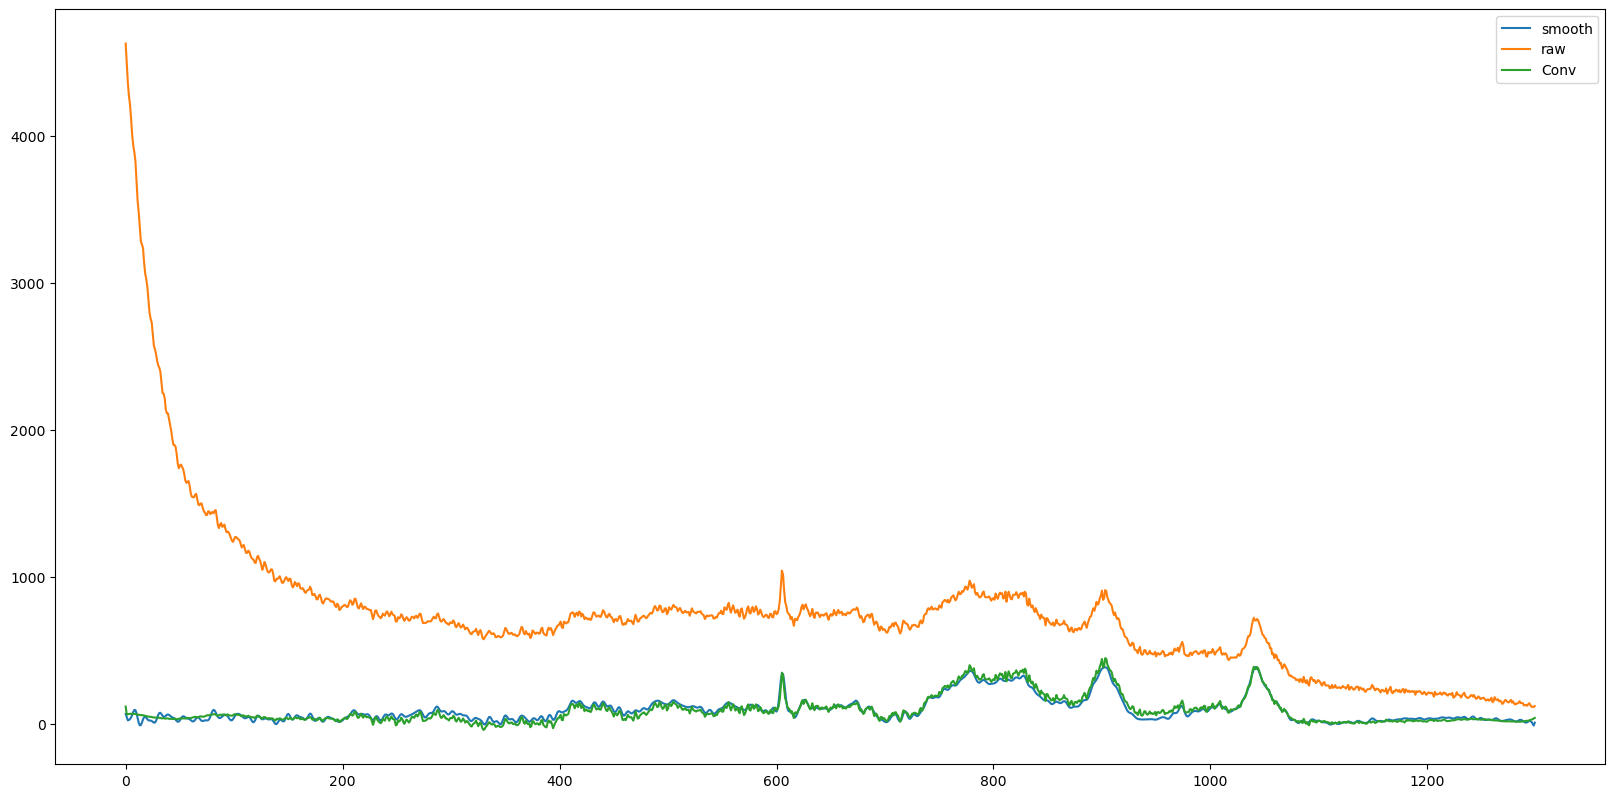

  2022-09-28 18:09:36|   600/ 2695| bits: 450.265289


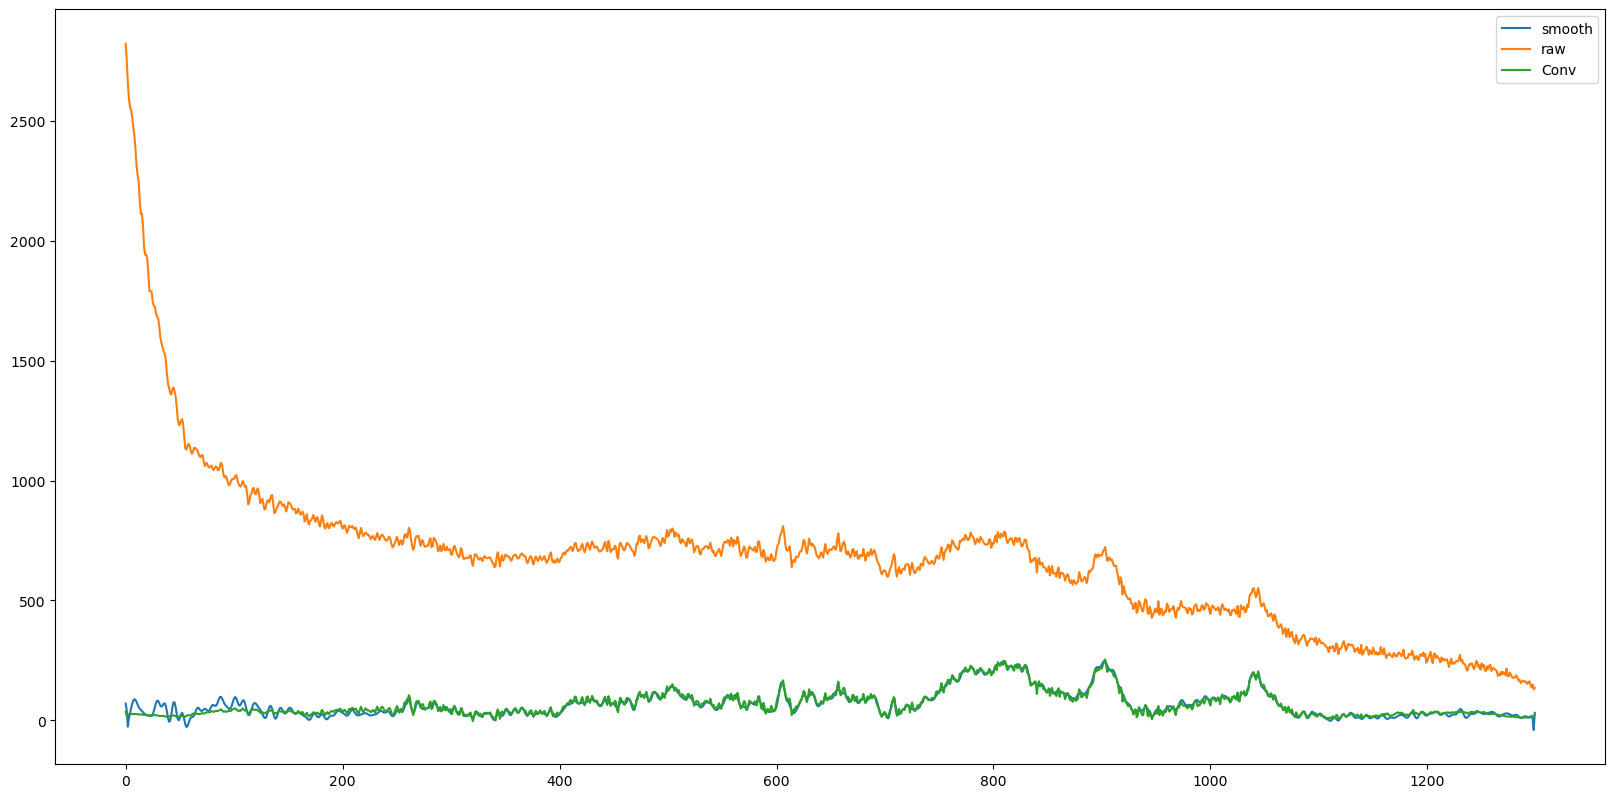

  2022-09-28 18:09:39|   700/ 2695| bits: 339.053833


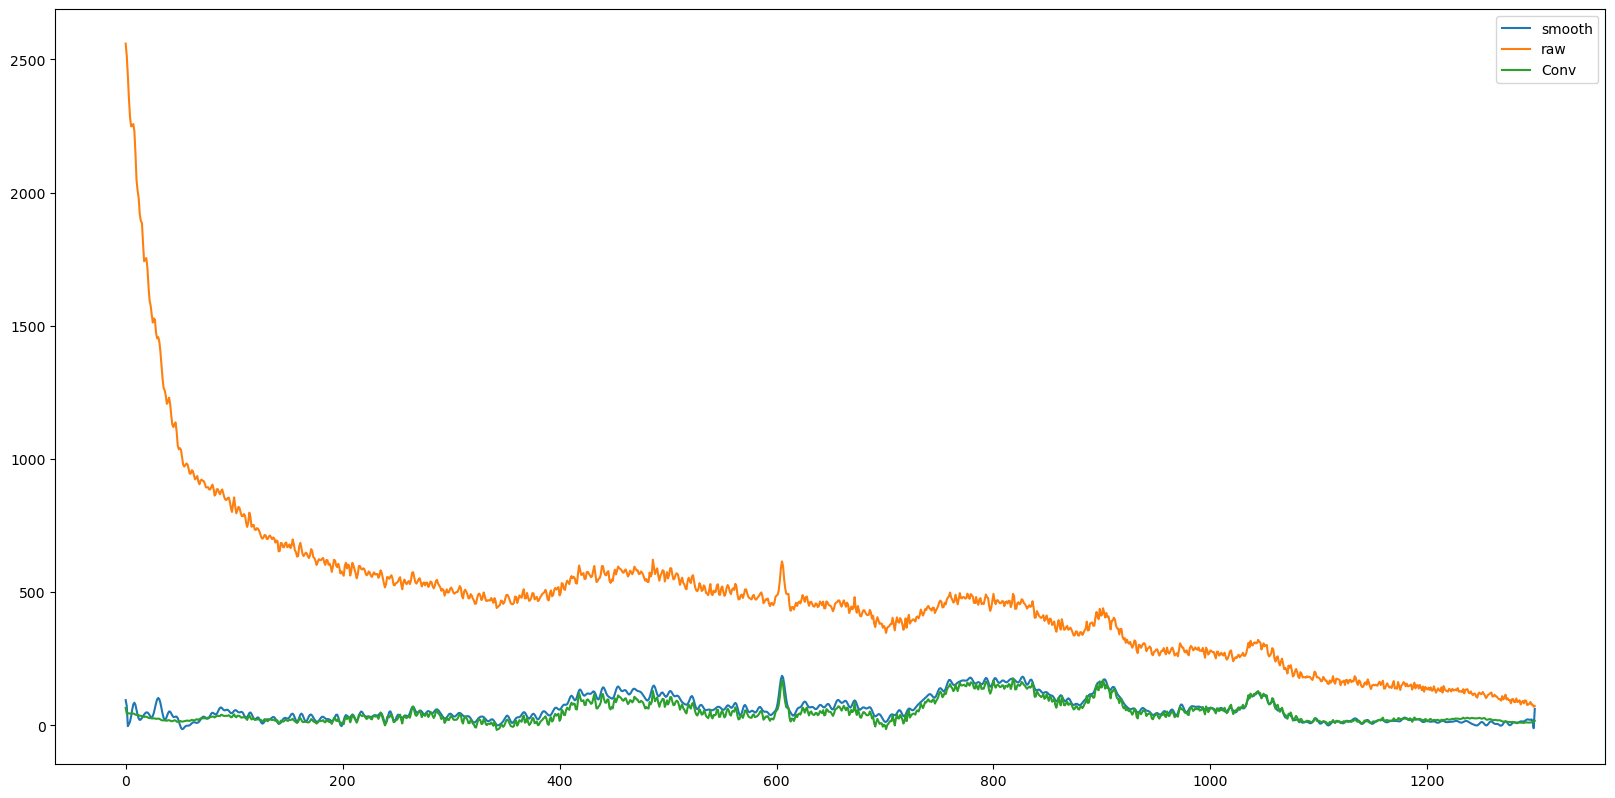

  2022-09-28 18:09:43|   800/ 2695| bits: 306.666962


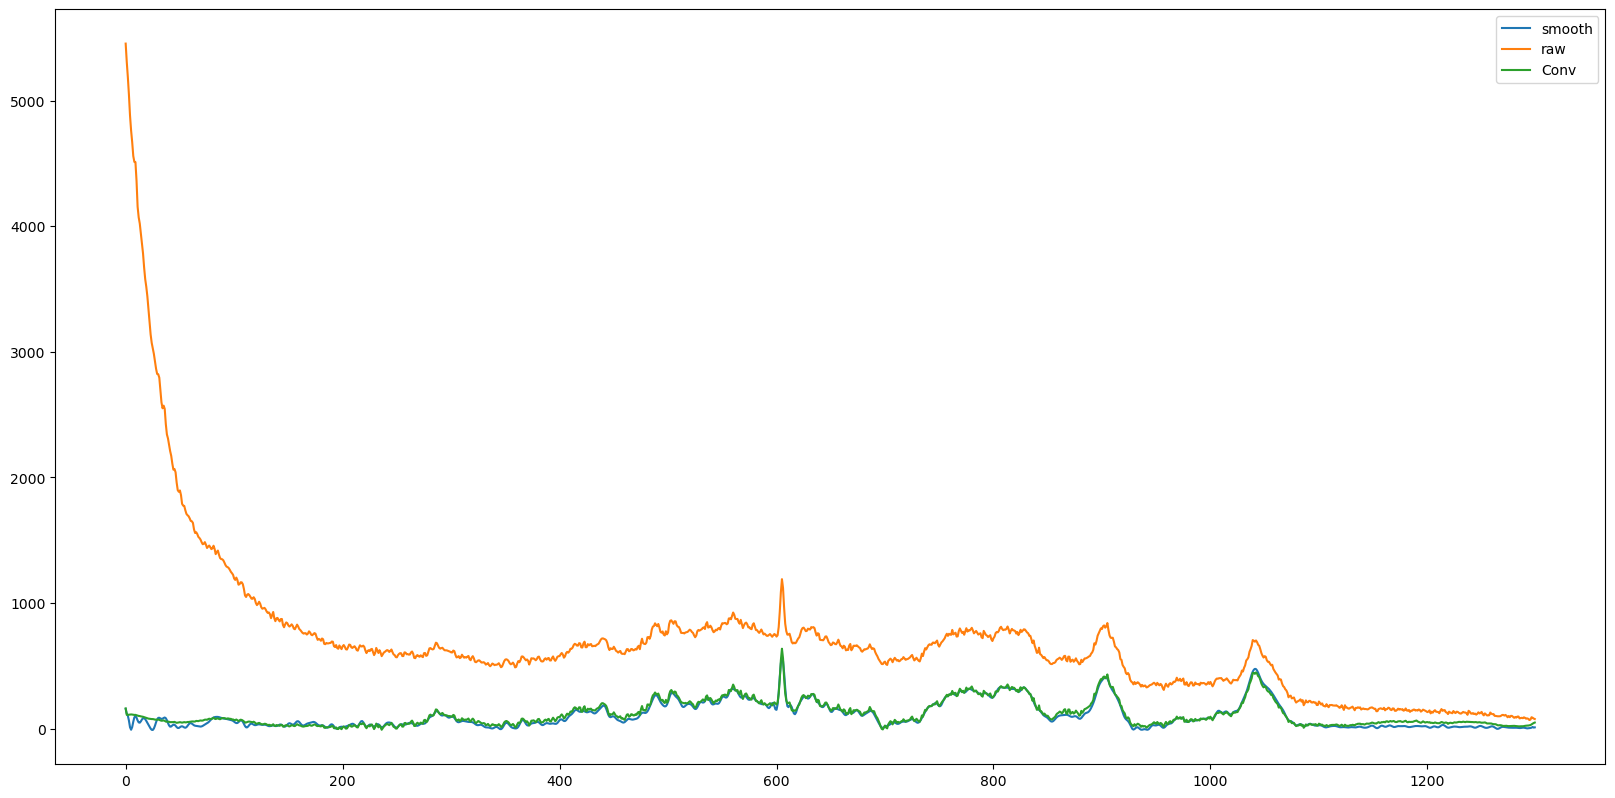

  2022-09-28 18:09:46|   900/ 2695| bits: 506.809235


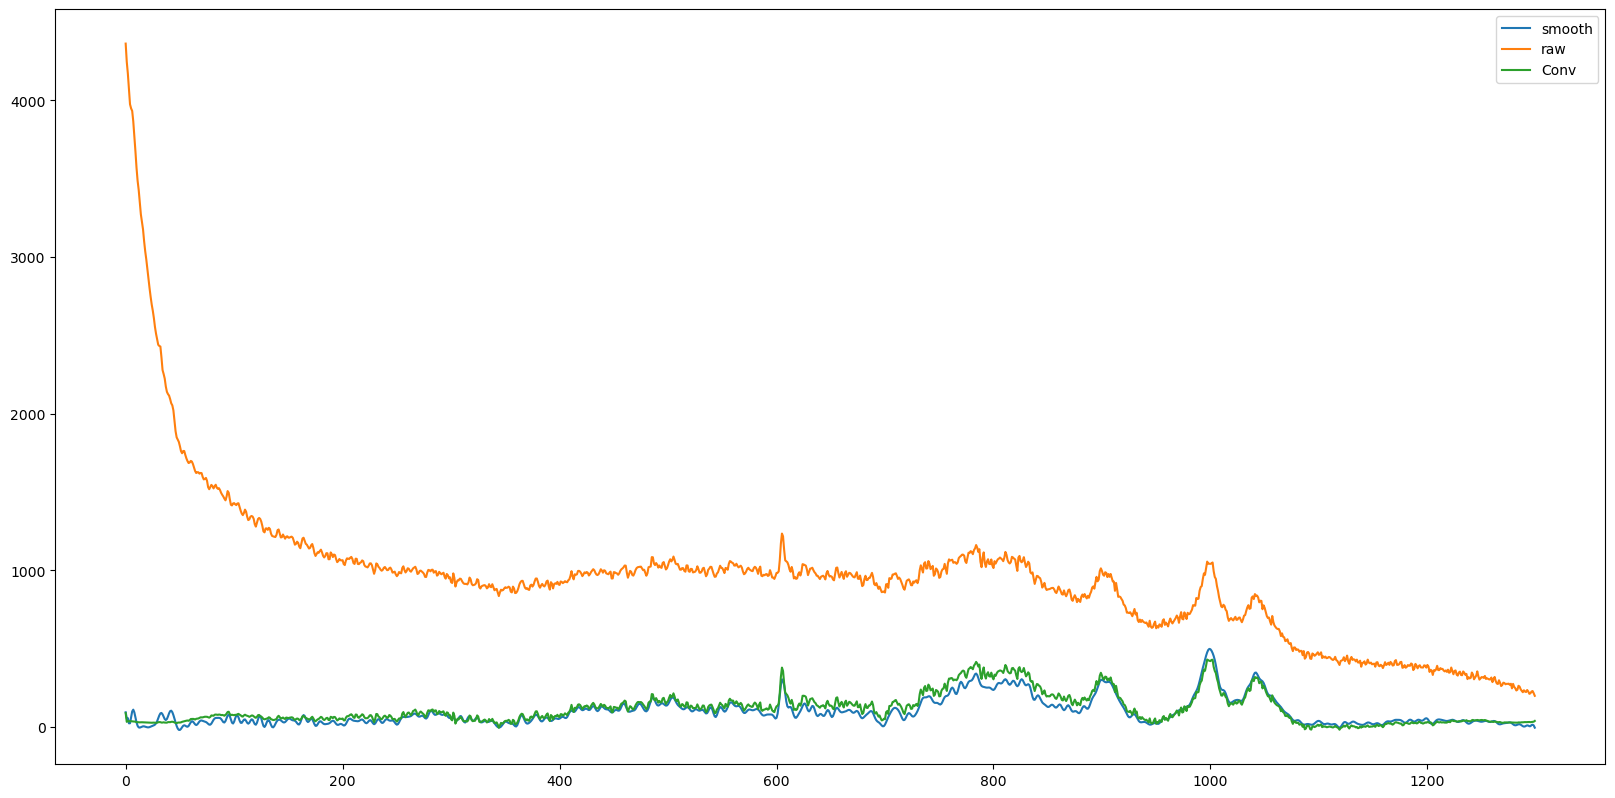

  2022-09-28 18:09:50|  1000/ 2695| bits: 2163.765869


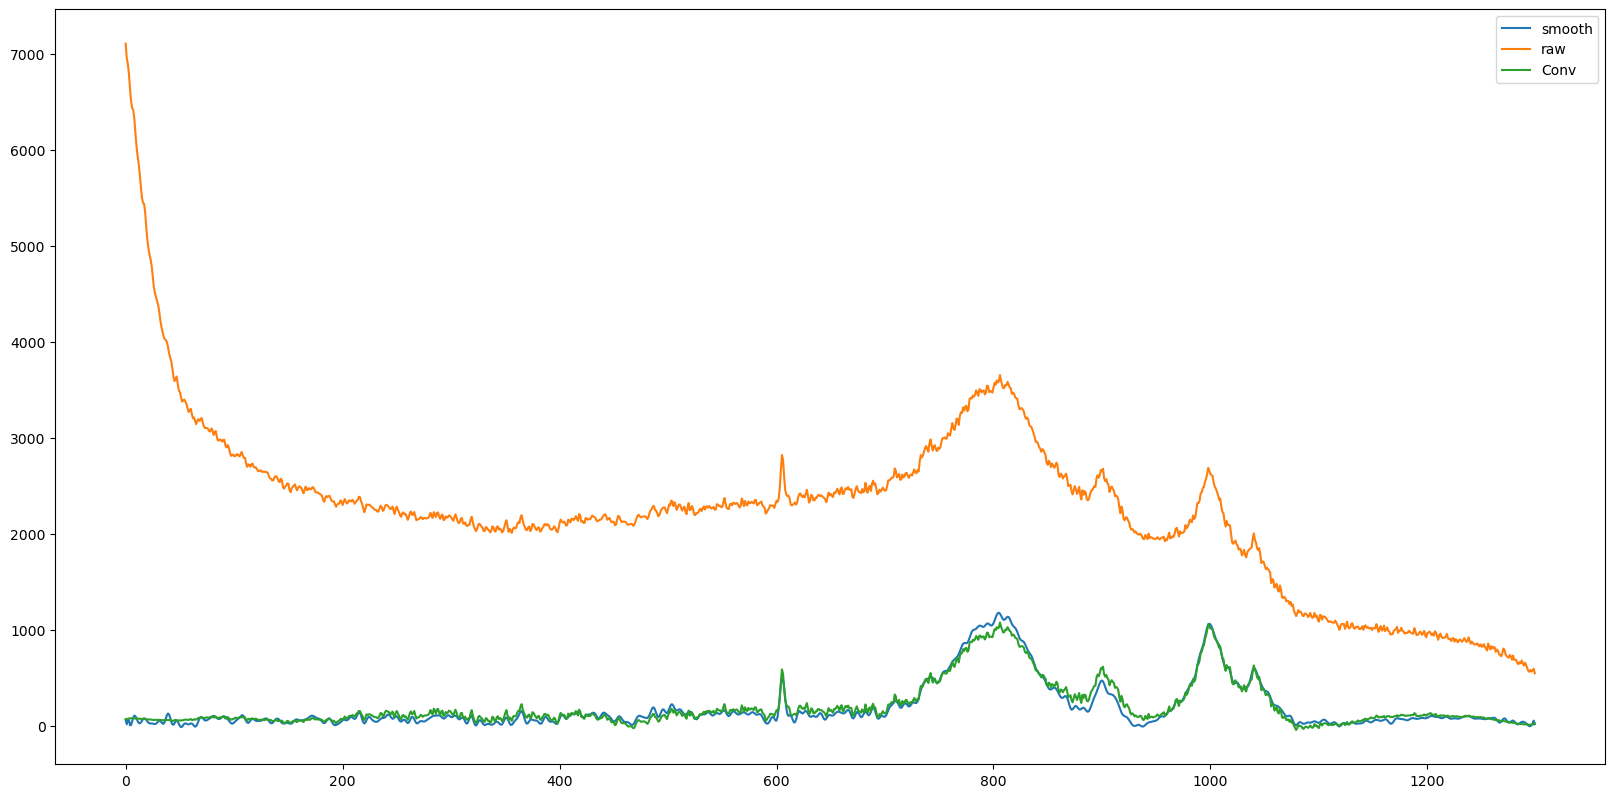

  2022-09-28 18:09:53|  1100/ 2695| bits: 1094.830200


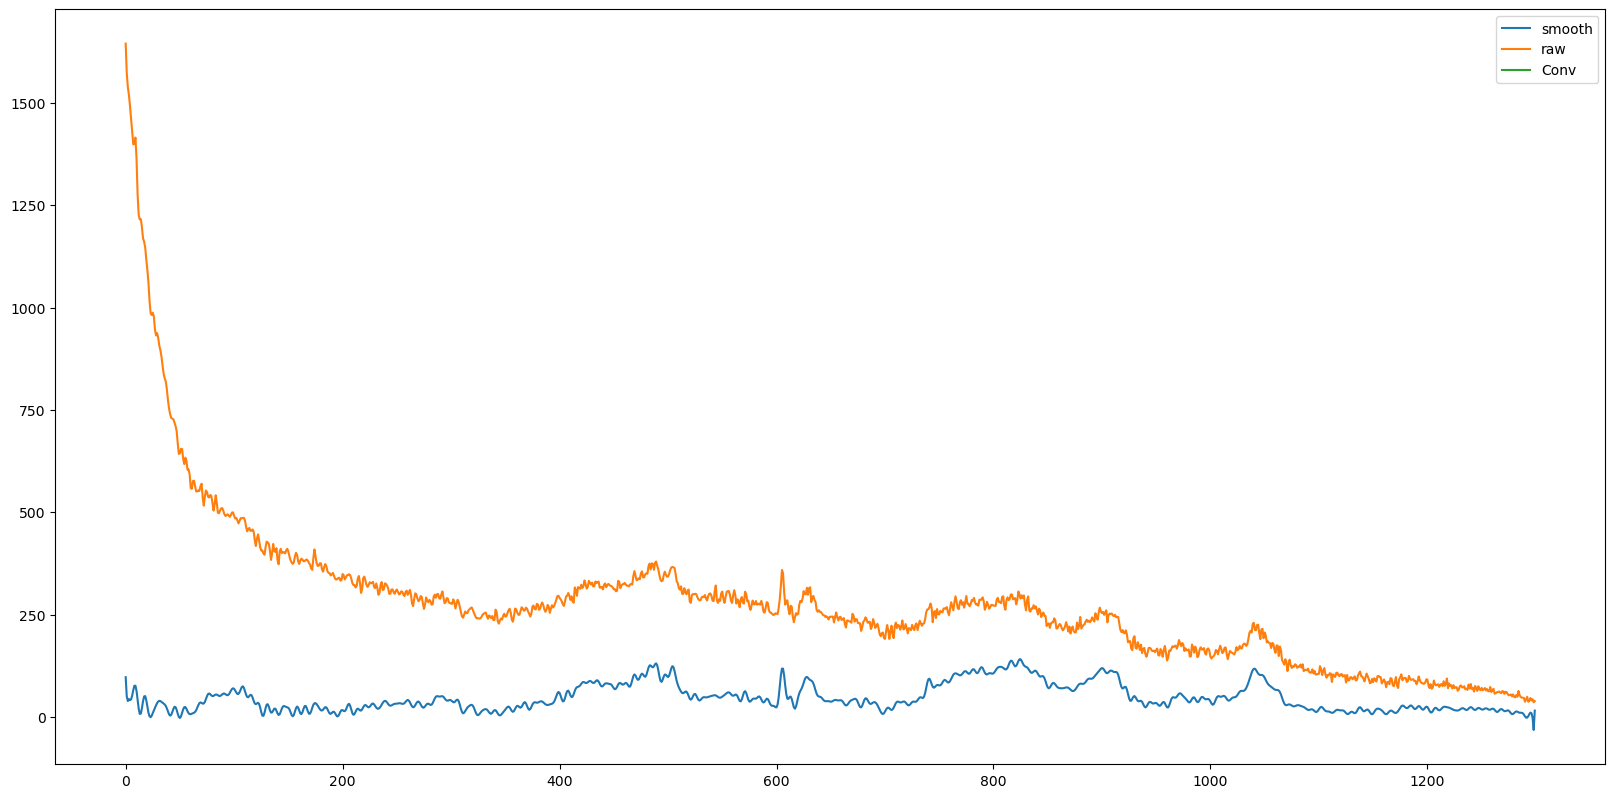

  2022-09-28 18:09:56|  1200/ 2695| bits: nan


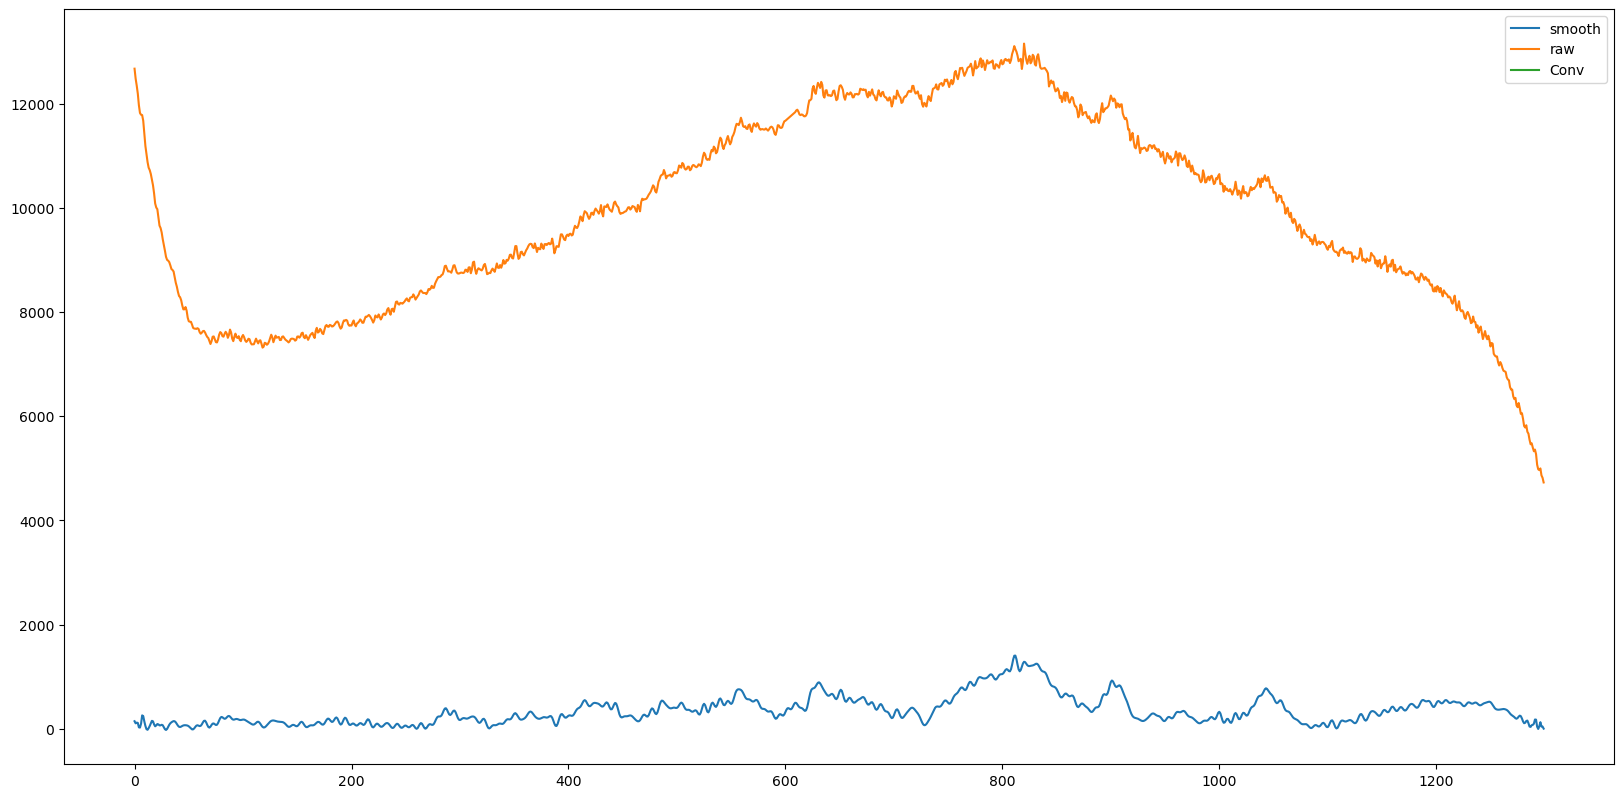

  2022-09-28 18:09:59|  1300/ 2695| bits: nan


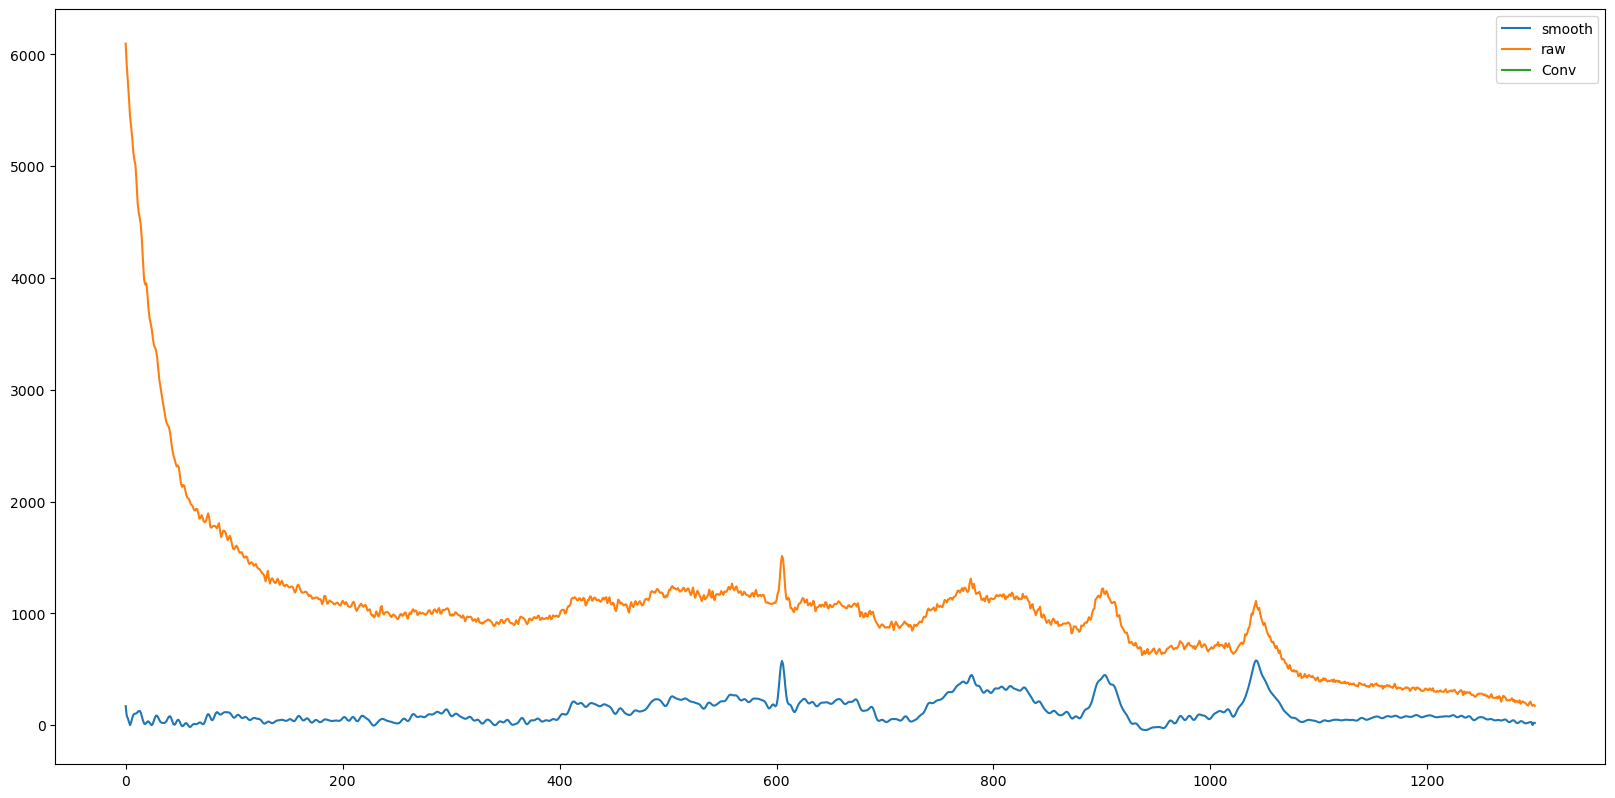

  2022-09-28 18:10:02|  1400/ 2695| bits: nan


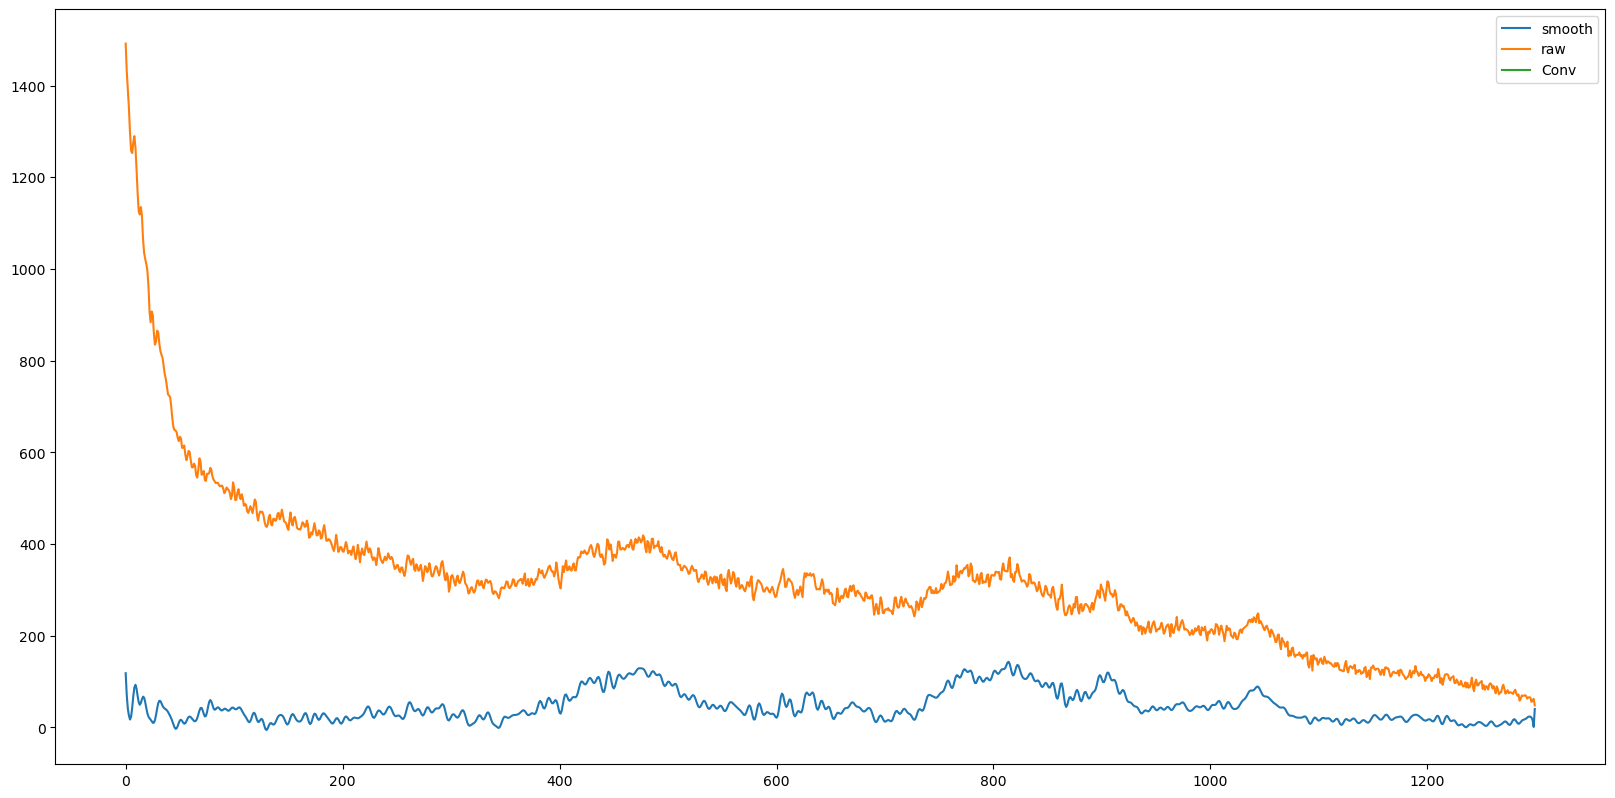

  2022-09-28 18:10:05|  1500/ 2695| bits: nan


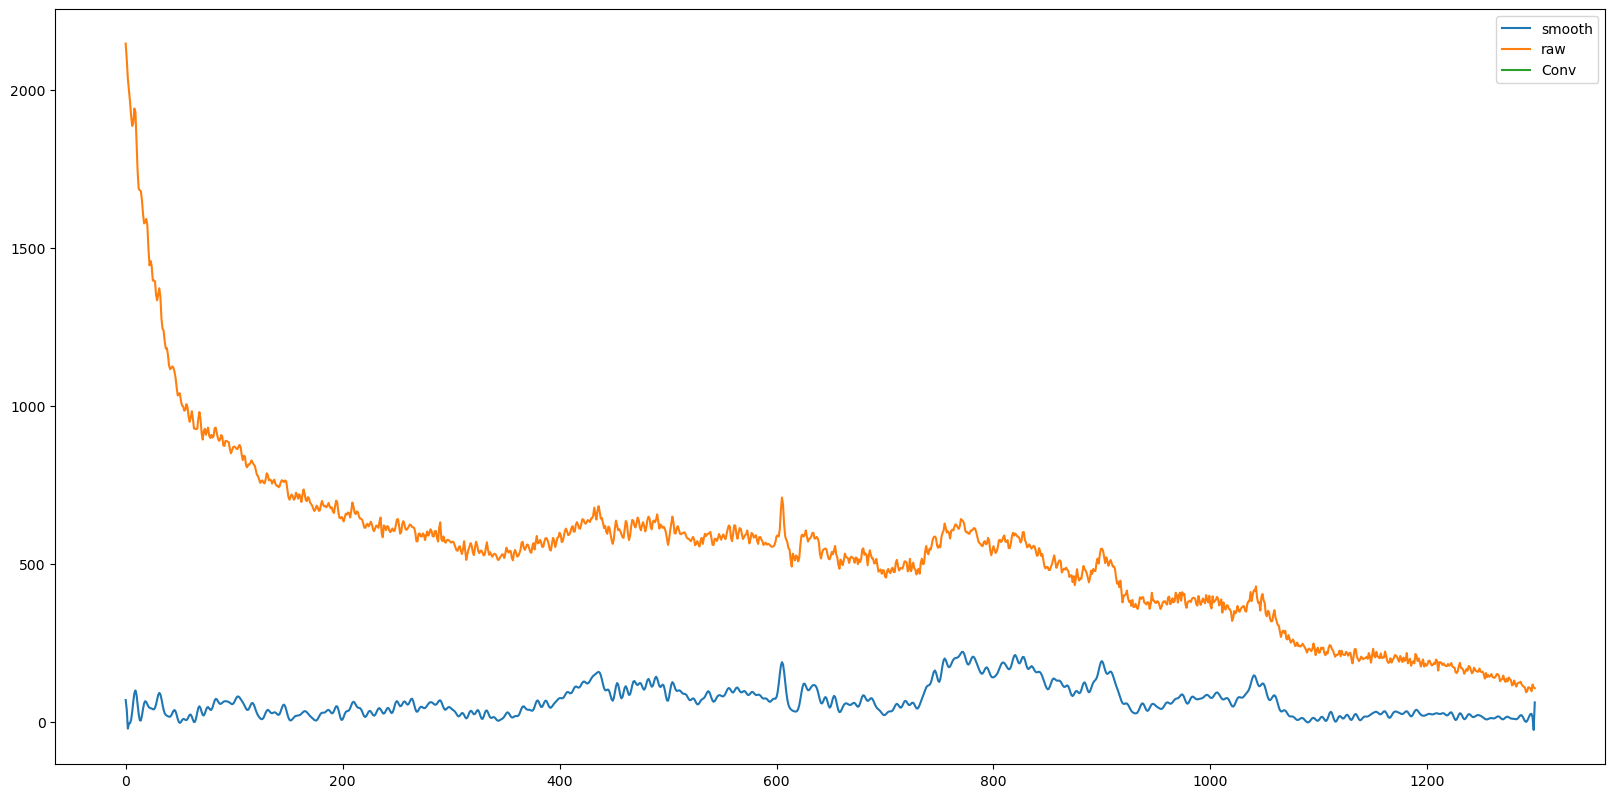

  2022-09-28 18:10:08|  1600/ 2695| bits: nan


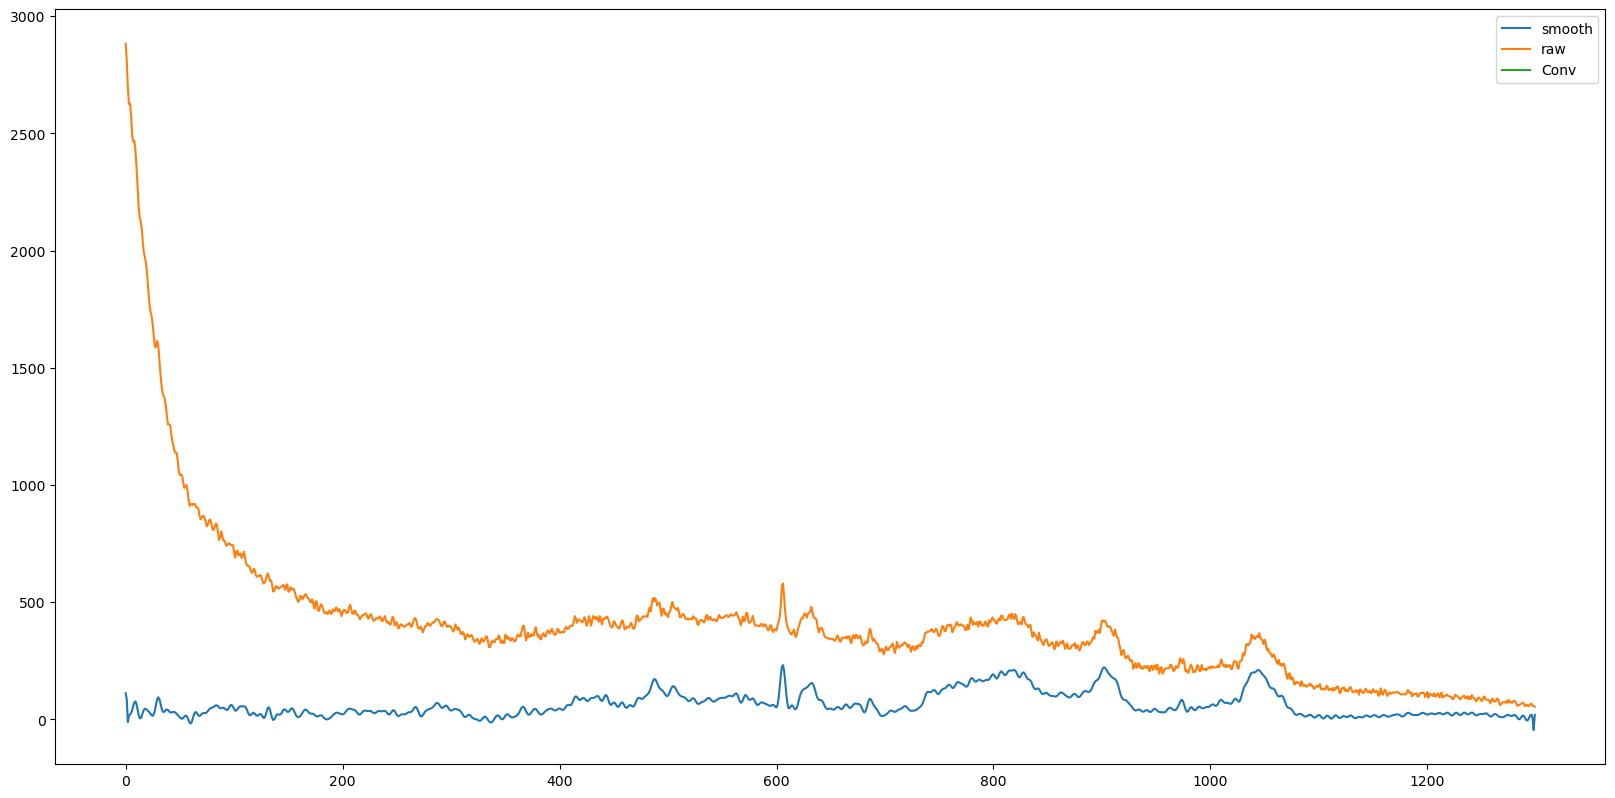

  2022-09-28 18:10:11|  1700/ 2695| bits: nan


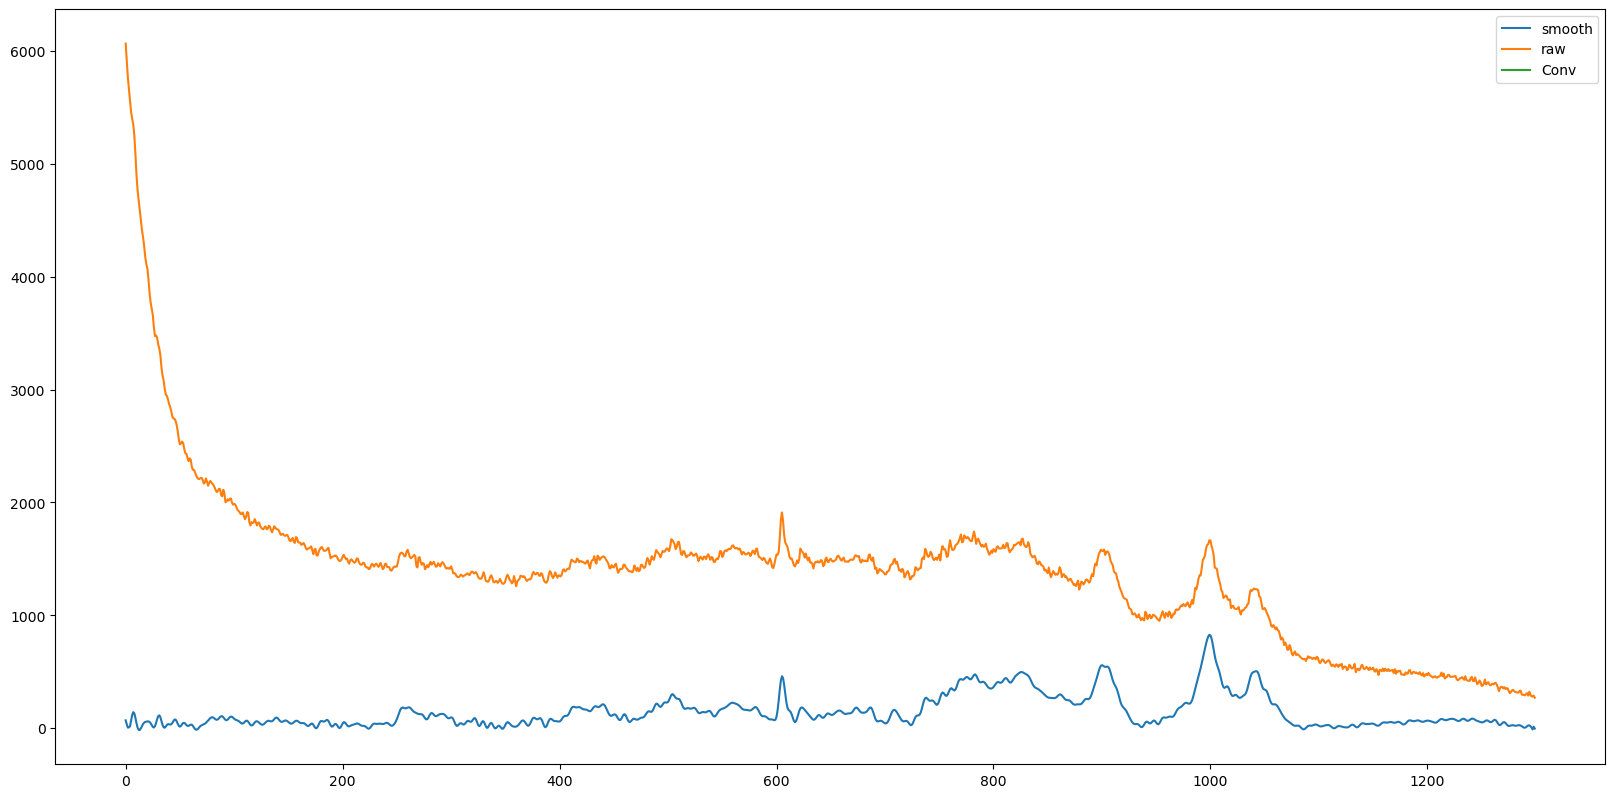

  2022-09-28 18:10:15|  1800/ 2695| bits: nan


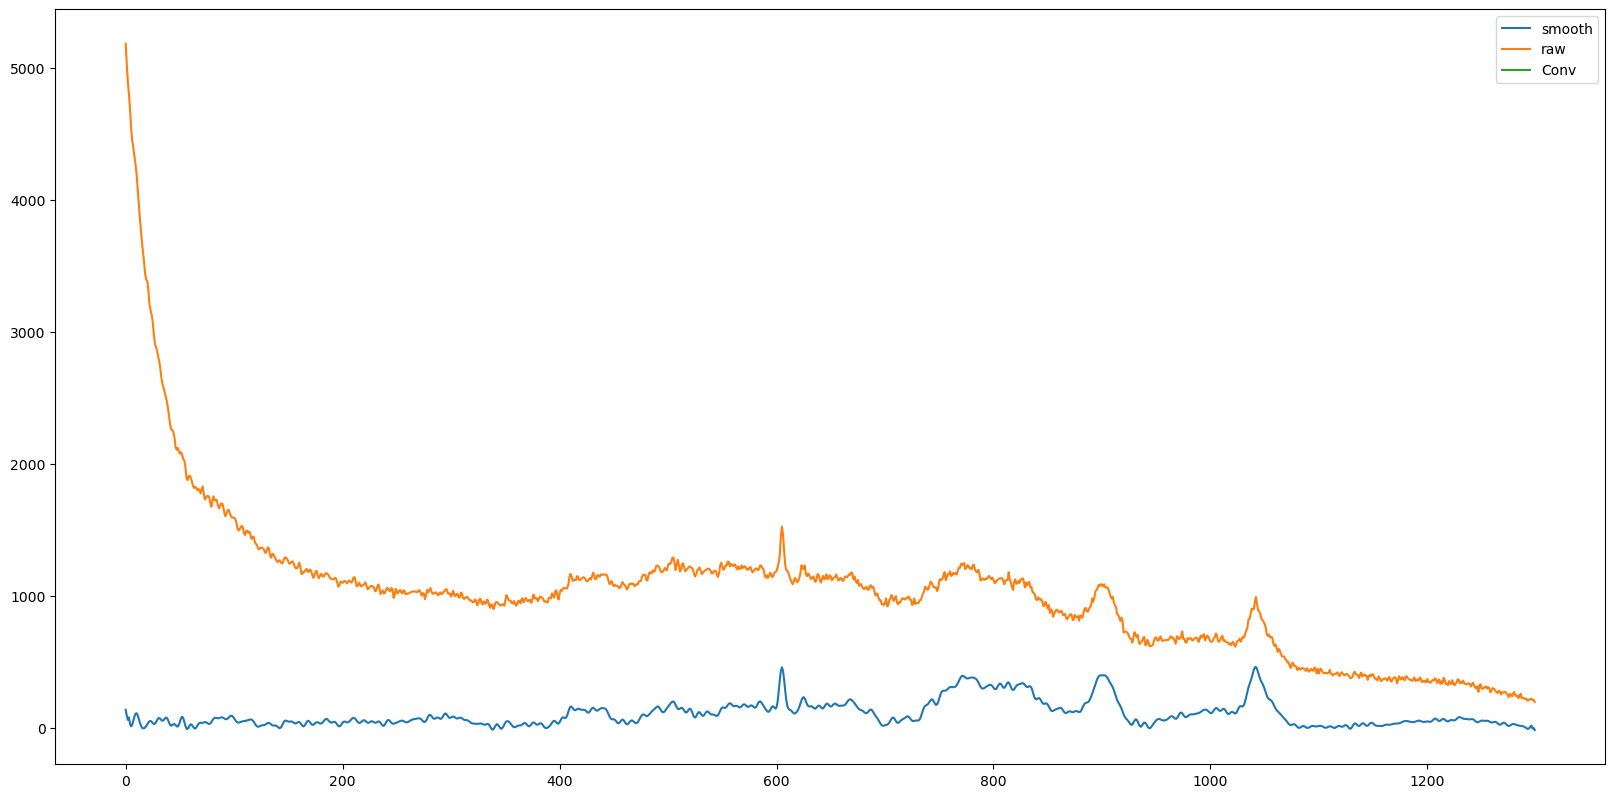

  2022-09-28 18:10:19|  1900/ 2695| bits: nan


KeyboardInterrupt: 

In [8]:
rvc = SupervisedClassifier(**kwargs)
rvc.fit(data)
